This notebook was made from scratch by me.  
The idea is reducing the 800,000 long mesurements to some shorter vector that is more fitted to a LSTM.  
This code below transform the 800.000 mesurements of the 3 diferent phases in a unique (80, 39) matrix.  
The matthews ocrrelation and attention functions are not mine.  

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
from keras.layers import *
from keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend as K
print(os.listdir("../input"))

/home/cwademo123/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['metadata_test.csv', 'metadata_train.csv', 'test.parquet.zip', 'train.parquet', 'test.parquet', 'train.parquet.zip', 'sample_submission.csv']


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [3]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [4]:
df_train = pd.read_csv('../input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [5]:
max_num = 127
min_num = -128

In [6]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [7]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        covar = std / mean
        asymmetry = mean - percentil_calc[4]
        new_ts.append(np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc]))
    return np.asarray(new_ts)

In [8]:
def prep_data(start, end):
    #praq_train = pq.read_pandas('../input/train.parquet').to_pandas()
    praq_train = pq.read_pandas('../input/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    #for id_measurement in tqdm(df_train.index.levels[0].unique()):
    for id_measurement in df_train.index.levels[0].unique()[int(start/3):int(end/3)]:
        X_signal = []
        for phase in [0,1,2]:
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            if phase == 0:
                y.append(target)
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [9]:
total_size = len(df_train)

In [11]:
[(0, int(total_size/2)), (int(total_size/2), total_size)]

[(0, 4356), (4356, 8712)]

In [13]:
start = 0
end = 4356 

df_train.index.levels[0].unique()[int(start/3):int(end/3)]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           dtype='int64', name='id_measurement', length=1452)

In [14]:
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [ ]:
X_signal = []
signal_id = 1

X_signal.append(transform_ts(praq_train[str(signal_id)]))


In [ ]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        covar = std / mean
        asymmetry = mean - percentil_calc[4]
        new_ts.append(np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc]))
    return np.asarray(new_ts)

In [5]:
max_num = 127
min_num = -128

In [6]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [17]:
min_data = min_num
max_data = max_num

ts = pq.read_pandas('../input/train.parquet', columns=[str(1)]).to_pandas()

In [21]:
ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]

,1
0,0.011765
1,0.003922
2,-0.003922
3,0.011765
4,0.003922
5,0.003922
6,0.011765
7,0.003922
8,0.003922
9,0.003922


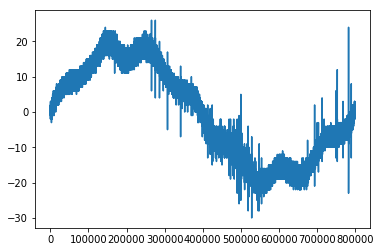

In [26]:
plt.plot(ts)

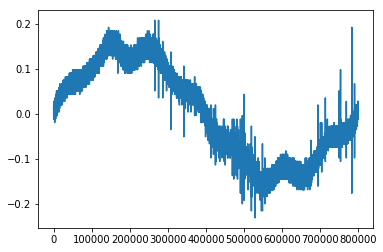

In [25]:
plt.plot(ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0])

In [22]:
(ts + abs(min_data)) / (max_data + abs(min_data))

,1
0,0.505882
1,0.501961
2,0.498039
3,0.505882
4,0.501961
5,0.501961
6,0.505882
7,0.501961
8,0.501961
9,0.501961


In [19]:
range_needed=(-1,1)

In [20]:
range_needed[0]

-1

In [28]:
n_dim =160
sample_size = 800000

bucket_size = int(sample_size / n_dim)

In [29]:
ts_range = ts_std[0:0 + bucket_size]
mean = ts_range.mean()

In [32]:
np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])

array([0.49019608, 0.49803922, 0.50196078, 0.50588235, 0.50588235,
       0.50980392, 0.51764706])

In [33]:
percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
max_range = percentil_calc[-1] - percentil_calc[0]

In [35]:
asymmetry = mean - percentil_calc[4]

In [36]:
asymmetry

1   -0.00163
dtype: float64

In [34]:
max_range

0.027450980392156932

In [38]:
std = ts_range.std()

In [41]:
std_top = mean + std
std_bot = mean - std
covar = std / mean

In [44]:
np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc])

array([1    0.504253
dtype: float64, 1    0.507704
dtype: float64,
       1    0.500801
dtype: float64, 0.027450980392156932,
       1    0.006845
dtype: float64, 1   -0.00163
dtype: float64,
       0.49019607843137253, 0.4980392156862745, 0.5019607843137255,
       0.5058823529411764, 0.5058823529411764, 0.5098039215686274,
       0.5176470588235295], dtype=object)

In [ ]:
for i in range(0, sample_size, bucket_size):
    ts_range = ts_std[i:i + bucket_size]
    mean = ts_range.mean()
    std = ts_range.std()
    std_top = mean + std
    std_bot = mean - std
    percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
    max_range = percentil_calc[-1] - percentil_calc[0]
    covar = std / mean
    asymmetry = mean - percentil_calc[4]
    new_ts.append(np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc]))

In [ ]:
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

In [ ]:
print(X.shape, y.shape)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [ ]:
model = model_lstm(X_train.shape)
print(model.metrics_names)
model.summary()

In [ ]:
ckp = ModelCheckpoint('weights.h5', save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
model.fit(X_train, y_train, batch_size=100, epochs=100, validation_data=[X_valid, y_valid], callbacks=[ckp])

In [ ]:
%%time
# 25ms in Kernel
meta_test = pd.read_csv('../input/metadata_test.csv')

In [ ]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

In [ ]:
%%time
# About 10min in Kernel
first_sig = meta_test.index[0]
n_parts = 10
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)
start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []
for start, end in start_end:
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(subset_test.columns):
        id_measurement, phase = meta_test.loc[int(i)]
        subset_test_col = subset_test[i]
        subset_trans = transform_ts(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])

In [ ]:
X_test_input = np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
X_test_input.shape

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
print(len(submission))
submission.head()

In [ ]:
model.load_weights('weights.h5')

In [ ]:
pred = model.predict(X_test_input, batch_size=300)

In [ ]:
pred_3 = []
for pred_scalar in pred:
    for i in range(3):
        pred_3.append(int(pred_scalar > 0.4))

In [ ]:
submission['target'] = pred_3

In [ ]:
submission.to_csv('submission.csv', index=False)